# Technical notebook - Exploratory Data Analysis

### About Lending Club

Lending Club is the world leader in p2p lending having issued over ($9 billion) dollars in loans since they began in 2007. They are growing at a rate in excess of (150% a year).

source: https://www.lendacademy.com/lending-club-review/

### How it Works

Peer to peer lending at Lending Club is a very simple process. It begins with the borrower. They apply for a loan and if they meet certain criteria (such as a minimum 660 FICO score) their loan is added to Lending Club’s online platform. Investors can browse the loans on the platform and build a portfolio of loans. The minimum investment an investor can make is just $25 per loan. Each portion of a loan is called a note and smart investors build a portfolio of notes to spread their risk among many borrowers.

Lending Club will perform some level of verification on every borrower. As this verification process is happening investors can be funding portions of the loans. If the borrower passes verification the loan is approved for investors and will be issued to the borrower if fully funded. If the borrower fails verification the loan will not be issued. It will be deleted from the platform and all money that had been invested will be returned to the respective investors.

A loan can stay on the platform for up to 14 days. Most loans are funded much quicker than that and once funded the loan will be deleted from the platform. Approved borrowers will receive their money (less an origination fee) in just a couple of business days once funding is complete and then begin making payments within 30 days. These payments will be for principal plus interest on a standard amortization schedule.

### Explanation of loan grades

Lending Club categorizes borrowers into seven different loan grades: A through G. Within each loan grade there are five sub-grades meaning there are 35 total loan grades for borrowers from A1 down to G5. Where a borrower is graded depends on many factors the most important of which is the data held in the borrower’s credit report. The better credit history a borrower has the better their loan grade with the very best borrowers receiving an A1 grade, which carries the lowest interest rate.

Lending Club will pull the latest credit report for every borrower and take the data held in that report and other factors such as loan amount and loan term to determine the interest rate. Lending Club provides more information on their Interest Rates and How We Set Them page on their site. Learn more about the Lending Club borrower experience in this video where I apply for a Lending Club loan.

### What are the Risks?

Every investor should consider the risks of an investment before committing their money.  Investing with p2p lending has a number of risks:

**Borrower defaults** – the loans are unsecured so an investor has little recourse if the borrower decides not to pay. The annual default rate across all grades at Lending Club is around 6 or 7% with higher risk borrowers having a higher default rate.

**Lending Club bankruptcy** – This is a much smaller risk today than it was several years ago because Lending Club is making money and has had an influx of cash with the recent IPO. But the risk will always be there. In the unlikely event of a bankruptcy, there is a backup loan servicer who will take over servicing the loans but there would likely be some disruption and investors could lose some principal.

**Interest rate risk** – the loan terms are three or five years so during this time interest rates could increase substantially. If an FDIC insured investment is paying 6% it makes investing in a Lending Club loan at 7% not the best investment.

**Poor loan diversification** – many new investors get caught in this trap. They do not take advantage of the \\$25 minimum investment. If you invest in 20 loans at \\$250 you are running a much higher risk than if you invest in 200 loans at \\$25. If you only have 20 loans one default could wipe out most of your gains.

**Liquidity risk** – There is a secondary market on Lending Club where loans can be sold but if you need to liquidate your entire investment you will likely lose some principal in the process.

**Market-wide event or recession** – While p2p lending has been around since the latest recession in 2008, the asset class still remains untested when platforms were originating significant volumes. In a recession, defaults will increase and thus will result in a decrease in investor returns.


### !! **This analysis focuses on borrower defaults and tries to identify a better classification** !!

### Data source:

https://www.lendingclub.com/info/download-data.action


Data includes yearly consumer loans given out with information was available at the time of the application and payment information. 

They also provide a short description of the columns.

This analysis is based on **LendingClub loan data from 2014.**

### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# from loan_helper import data_cleaning functions
from loan_helper import data_converting

#SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



Using TensorFlow backend.


### Importing Dataset

In [1]:
# !ls -lath LendingClub

In [3]:
#reading excel
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

Reading from csv file:

In [5]:
# reading Lending Club loan data from 2014
# data_lc = pd.read_csv('LendingClub/LoanStats3c_securev1.csv', low_memory=False, header=1)
# data_lc.shape

Reading from zip file:

In [4]:
#read in Lending Club loan data from zip file
from zipfile import ZipFile
zip_file = ZipFile('LendingClub/LoanStats3c_securev1.csv.zip')
data_lc = pd.read_csv(zip_file.open('LoanStats3c_securev1.csv'), low_memory=False, header=1)
data_lc.shape

(235631, 150)

In [5]:
data_lc.loan_amnt.isna().sum() #there are rows without loan amount

2

In [6]:
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(235629, 150)

## I. Feature selection and feature engineering

### 1. Understanding the columns

In order to understand the columns we created a dataframe with column names, two examples, datatype, number of missing values, and the long description. The dataframe was exported to excel to make decision on columns. The result is stored in col_selection.xlsx.

In [9]:
from loan_helper import column_description
desc = column_description(data_lc, description) #column_description() is my own function to create this table

In [10]:
pd.set_option('display.max_colwidth', -1) #this allows us to see the very long description, if exceeds 50 char
desc.head(4)

,col_name,exmp1,exmp2,dtype,Description,nan_counts
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629
2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0


In [11]:
desc.to_excel('col_desc_2014.xlsx')

### 2. First round feauture selection

Originally the dataset contained **150 columns/features**. Features were reduced due to many reasons listet below:

- Discarded columns which were holding **irrelevant** information:
    - id, member_id, url, policy_code, application_type, annual_inc_joint, verification_status_joint, acc_now_delinque
- Discarded columns which contained **redundant** information:
    - funded_amnt, funded_amnt_inv (the difference is funded by LC itself), int_rate, sub_grade, title, fico_range_high, desc (given as purpose)
- Discarded columns that contained **payment or collection** information (34 columns)
- Discarded columns that contained information that were not available at the time of credit application, **future info**
    - issue_d, pymnt_plan, initial_list_status, last_credit_pull_d, last_fico_range_high, last_fico_range_low
- Discarded features that require **too much data processing**
    - emp_title (due to the free format), zip_code (there is a state instead)
- Discarded columns with **only missing values** (31 columns)

In [7]:
# !ls

In [10]:
col_selection = pd.read_excel('col_selection_2014.xlsx', index_col=0)
col_selection.Cause.value_counts() #these are the different causes to discard columns

missing         27
collection      22
payment_info    12
irrelevant       9
redundant        7
future_info      6
poor_format      2
Name: Cause, dtype: int64

In [11]:
col_selection.head()

,col_name,exmp1,exmp2,dtype,Description,nan_counts,Decision,Cause
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0,remove,irrelevant
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629,remove,irrelevant
2,loan_amnt,7650,23325,float64,The listed amount of the loan applied for by t...,0,keep,NaN
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at tha...,0,remove,redundant
4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for th...,0,remove,redundant


#### Evidences

In [17]:
print('Different types of applications:')
data_lc.application_type.unique().tolist() #there are only individual applications, no joint applications

Different types of applications:


['Individual']

In [18]:
print('The difference between high and low fico scores, and its distributions:')
(data_lc.fico_range_high - data_lc.fico_range_low).value_counts() 

The difference between high and low fico scores, and its distributions:


4.0    235615
5.0        14
dtype: int64

In [19]:
print('The number of different employment title:')
len(data_lc.emp_title.unique()) 

The number of different employment title:


75353

In [20]:
print('The number of different ZIP codes:') #as a qualitative value there is no reason to keep it
len(data_lc.zip_code.unique()) 

The number of different ZIP codes:


866

In [21]:
print('The number of columns with missing values')
sum(data_lc.isna().sum() == len(data_lc))

The number of columns with missing values


31

In [35]:
print('The columns with full of missing values:')
col_selection.loc[col_selection.nan_counts == 235629, ['col_name', 'nan_counts']].col_name.unique().tolist()

The columns with full of missing values:


['member_id',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

#### Removing columns

In [34]:
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
print('Number of selected columns:', len(selected_col))

Number of selected columns: 65


In [39]:
dataset = data_lc.loc[:, selected_col]
print(f'After removing features, the dataset contains {dataset.shape[0]:,} rows and {dataset.shape[1]} columns.')
# dataset.shape

After removing features, the dataset contains 235,629 rows and 65 columns.


### 3. Determine the target feature

#### For creating the tarrget variable we will use the loan_status variable
#### Meaning of the loan_status categories:
- <b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

- <b>Current:</b> Loan is up to date on all outstanding payments. 

- <b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

- <b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

- <b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

- <b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

- <b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [36]:
pd.DataFrame(dataset.loan_status.value_counts())

,loan_status
Fully Paid,189555
Charged Off,41609
Current,4215
Late (31-120 days),144
In Grace Period,76
Late (16-30 days),30


In [37]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'])

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,
36 months,22315,0,140255,0,0,0
60 months,19294,4215,49300,76,30,144


We decided to ignore the 'gray' categories (250 rows), where there might chance of the recovery of the loan. We will consider the loan being **defaulted (1) if it was charged off**, and **non defaulted (0) if it was fully paid or current**. The 'Current' category consists of only the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category.

In [40]:
#Determine default categories into a 'target' variable. 
# The gray category gets -1 and will be removed from the dataset.
target = {'Fully Paid':0, 'Charged Off':1, 'Current':0, 'Late (31-120 days)':-1, 'In Grace Period':-1,
         'Late (16-30 days)':-1}
dataset['target'] = dataset.loan_status.apply(lambda x: target[x])

#dropped the rows where the loan status was different
dataset = dataset[dataset.target != -1]

#remove loan_status, default replace it
dataset = dataset.drop(columns='loan_status', axis=1)

#reset index
dataset = dataset.reset_index(drop=True)

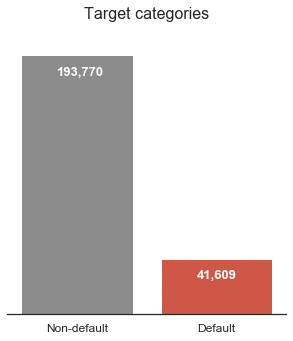

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='white')
fig1 = plt.figure(figsize=(5,5))
ax = sns.countplot(x = 'target', data=dataset, palette=["#8c8c8c", "#e54632"])
for p in ax.patches:
        ax.annotate('{:,}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()-15000), 
                    color='white', fontsize=13, fontweight='bold')

plt.title('Target categories\n', fontsize=16)
ax.set_xticklabels(['Non-default', 'Default'], fontsize=13)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
for pos in ['right', 'top', 'left']:
    ax.spines[pos].set_visible(False)
plt.yticks([])
fig1.savefig('Target_var');

### 4. Converting data types and EAD - object type data

- **term** should be converted into numeric
- **grade** should be converted into numeric due its meaning of an order
- **emp_length** (employment length) column should be converted to numeric, missing values converted to be -1
- **home_ownership** 'any' category (due to the very low num) is converted to be 'rent'
- reduced categories of loan **purpose** by aggregation of close categories
- **addr_state** was converted into **regions**, addr_state column was removed
- **earliest_cr_line** date was converted to numeric (years)
- **revol_util** (revolving utilization) was converted to numeric

The above transformations do not impact dataleakage and can be done before train - test split.

In [28]:
#columns which type is an object
dataset.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235379 entries, 0 to 235378
Data columns (total 9 columns):
term                   235379 non-null object
grade                  235379 non-null object
emp_length             223369 non-null object
home_ownership         235379 non-null object
verification_status    235379 non-null object
purpose                235379 non-null object
addr_state             235379 non-null object
earliest_cr_line       235379 non-null object
revol_util             235254 non-null object
dtypes: object(9)
memory usage: 16.2+ MB


#### $-->$ term

In [29]:
print(dataset.term.isna().sum()) #there is no missing value
dataset.term.value_counts()

0


 36 months    162570
 60 months    72809 
Name: term, dtype: int64

In [30]:
dataset['term'] = dataset.term.apply(lambda x: 36 if x == ' 36 months' else 60)

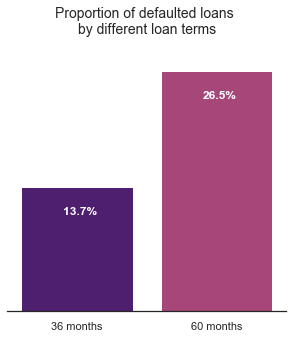

In [31]:
fig2 = plt.figure(figsize=(5,5))
ax = sns.barplot(x=['36 months', '60 months'], y=dataset.groupby('term').target.mean(),
                palette=sns.color_palette("magma", 3))
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.03), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans \nby different loan terms', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.3]);

#### $-->$ grade

In [32]:
dataset.grade.value_counts()

C    66505
B    61909
D    42916
A    36105
E    20055
F    6208 
G    1681 
Name: grade, dtype: int64

In [33]:
dataset.groupby('grade').target.mean()

grade
A    0.054037
B    0.110759
C    0.185400
D    0.253612
E    0.327898
F    0.366946
G    0.436050
Name: target, dtype: float64

In [34]:
#converting to numeric
grades = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
dataset['grade'] = dataset.grade.apply(lambda x: grades[x])

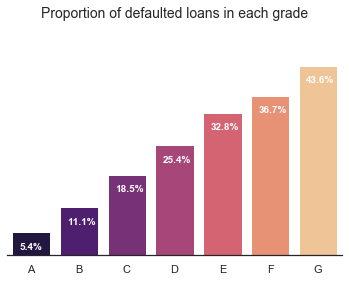

In [35]:
ax = sns.barplot(x=['A', 'B', 'C', 'D', 'E', 'F', 'G'], y=dataset.groupby('grade').target.mean(),
                palette='magma')
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()-0.04), 
                    color='white', fontsize=10, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each grade', fontsize=14, pad=20)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.5]);

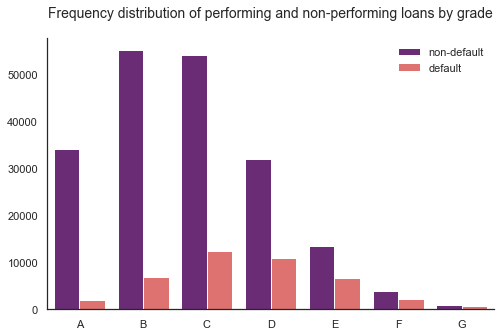

In [36]:
fig2 = plt.figure(figsize=(8,5))
sns.set(style="white")
ax = sns.countplot(x='grade', hue='target', data=dataset, order=[1,2,3,4,5,6,7], palette='magma')
plt.title('Frequency distribution of performing and non-performing loans by grade', fontsize=14, pad=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('')
plt.ylabel('')
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
ax.legend(labels=['non-default','default'], loc='upper right', frameon=False);

#### $-->$ emp_length

In [37]:
dataset.emp_length.value_counts()

10+ years    79404
2 years      20463
3 years      18255
< 1 year     17970
1 year       14575
4 years      13516
7 years      13084
5 years      13034
8 years      11842
6 years      11810
9 years      9416 
Name: emp_length, dtype: int64

In [38]:
dataset.emp_length.isna().sum()

12010

In [39]:
emp_lens = {'10+ years': 10, '9 years': 9, '4 years': 4, '2 years': 2, '< 1 year': 0,
            '1 year': 1, '6 years': 6, '5 years': 5, '8 years': 8, '7 years': 7, '3 years':3}
dataset['emp_length'] = dataset.emp_length.apply(lambda x: emp_lens.get(x,-1))

In [40]:
dataset.emp_length.value_counts()

 10    79404
 2     20463
 3     18255
 0     17970
 1     14575
 4     13516
 7     13084
 5     13034
-1     12010
 8     11842
 6     11810
 9     9416 
Name: emp_length, dtype: int64

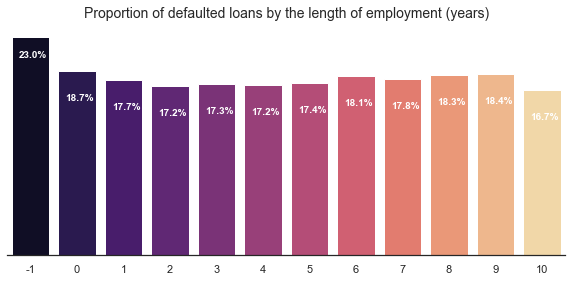

In [41]:
fig = plt.figure(figsize=(10,4))

ax = sns.barplot(x=list(range(-1,11)), y=dataset.groupby('emp_length').target.mean(),
                palette='magma')
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()-0.03), 
                    color='white', fontsize=10, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans by the length of employment (years)', fontsize=14, pad=20)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### $-->$ **home_ownership**

In [42]:
dataset.home_ownership.value_counts()

MORTGAGE    119808
RENT        92592 
OWN         22978 
ANY         1     
Name: home_ownership, dtype: int64

In [43]:
#converting the 'any' to 'rent'
dataset['home_ownership'] = dataset.home_ownership.apply(lambda x: 'RENT' if x=='ANY' else x)
dataset.home_ownership.value_counts()

MORTGAGE    119808
RENT        92593 
OWN         22978 
Name: home_ownership, dtype: int64

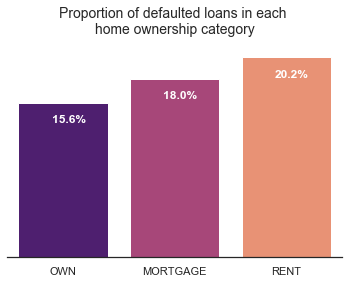

In [44]:
ax = sns.barplot(x=['OWN','MORTGAGE', 'RENT'], y=dataset.groupby('home_ownership').target.mean(),
                palette=sns.color_palette("magma", 3))
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each \nhome ownership category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### $-->$ **verification_status**

In [45]:
dataset.verification_status.value_counts()

Source Verified    99751
Not Verified       68492
Verified           67136
Name: verification_status, dtype: int64

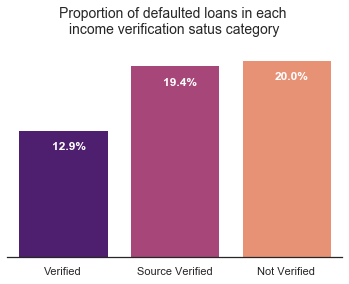

In [46]:
ax = sns.barplot(x=['Verified','Source Verified', 'Not Verified'], 
                 y=dataset.groupby('verification_status').target.mean(),
                 palette=sns.color_palette("magma", 3))
for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each \nincome verification satus category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.22]);

#### $-->$ **purpose**

In [47]:
dataset.purpose.value_counts()

debt_consolidation    142832
credit_card           55481 
home_improvement      13032 
other                 10360 
major_purchase        3854  
medical               2331  
small_business        2275  
car                   1832  
moving                1325  
vacation              1177  
house                 749   
renewable_energy      123   
wedding               8     
Name: purpose, dtype: int64

In [48]:
purposes = {'educational': 'other', 'vacation':'major_purchase', 'wedding':'major_purchase', 
            'renewable_energy':'home_improvement'}
dataset['purpose'] = dataset.purpose.apply(lambda x: purposes.get(x,x))

In [49]:
dataset.purpose.value_counts()

debt_consolidation    142832
credit_card           55481 
home_improvement      13155 
other                 10360 
major_purchase        5039  
medical               2331  
small_business        2275  
car                   1832  
moving                1325  
house                 749   
Name: purpose, dtype: int64

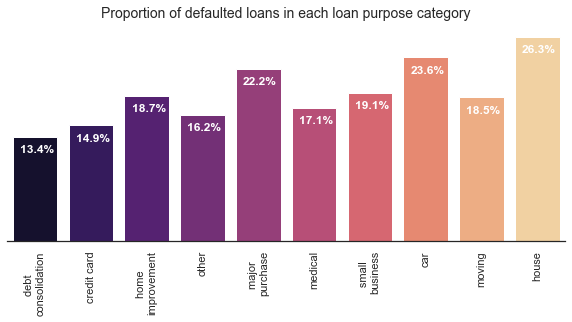

In [50]:
fig = plt.figure(figsize=(10,4))
ax = sns.barplot(x=list(range(1,11)), y=dataset.groupby('purpose').target.mean(), palette='magma')

for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans in each loan purpose category', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.28])
ax.set_xticklabels(['debt \nconsolidation', 'credit card', 'home \nimprovement', 'other', 'major \npurchase',
                    'medical', 'small \nbusiness', 'car', 'moving', 'house'], rotation=90);

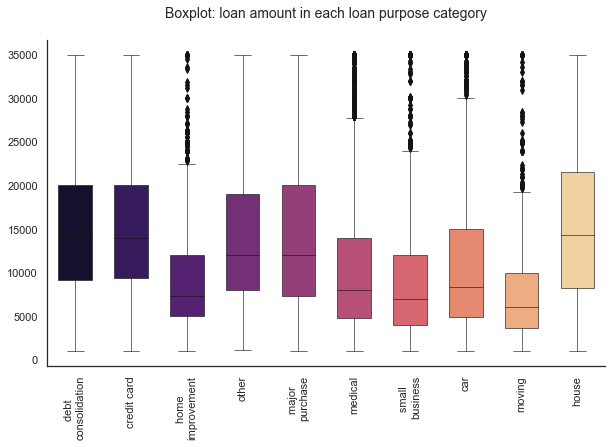

In [51]:
fig = plt.figure(figsize=(10,6))
ax = sns.boxplot(x="purpose", y='loan_amnt', data=dataset, palette='magma', width=0.6, linewidth=0.6)

plt.title(label = f'Boxplot for loan amount by purpose', pad=10, fontsize=14)
plt.xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.title('Boxplot: loan amount in each loan purpose category\n', fontsize=14)
plt.ylabel('')
ax.set_xticklabels(['debt \nconsolidation', 'credit card', 'home \nimprovement', 'other', 'major \npurchase',
                    'medical', 'small \nbusiness', 'car', 'moving', 'house'], rotation=90);

#### $-->$ **addr_state**

In [52]:
regions = {'W':  ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID'], 
               'SW': ['AZ', 'TX', 'NM', 'OK'],
               'SE': ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ],
               'MW': ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND'],
               'NE': ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']}

for region, states in regions.items():
        for state in states:
            dataset.loc[dataset.addr_state == state, 'region'] = region
dataset = dataset.drop(columns = ['addr_state'])

In [53]:
dataset.region.value_counts()

SE    57289
W     54205
NE    54165
MW    41786
SW    27934
Name: region, dtype: int64

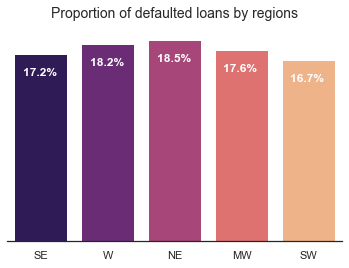

In [54]:
fig = plt.figure(figsize=(6,4))
ax = sns.barplot(x=['SE', 'W', 'NE', 'MW', 'SW'], y=dataset.groupby('region').target.mean(), palette='magma')

for p in ax.patches:
        ax.annotate('{:.1%}'.format(p.get_height()), (p.get_x()+0.13, p.get_height()-0.02), 
                    color='white', fontsize=12, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title('Proportion of defaulted loans by regions', fontsize=14)
plt.ylabel('')
plt.yticks([])
plt.ylim([0,0.2]);

#### $-->$ earliest_cr_line

In [55]:
dataset.earliest_cr_line.value_counts().head()

Aug-2001    1980
Aug-2000    1942
Sep-2000    1718
Aug-2002    1710
Aug-1999    1695
Name: earliest_cr_line, dtype: int64

In [56]:
#created years since the earliest_cr_line
dataset['earliest_cr_line'] = dataset.earliest_cr_line.apply(lambda x: 2015 - int(x[-4:]))

In [57]:
dataset.earliest_cr_line.value_counts().head()

14    17145
15    16869
16    15369
13    15368
12    13728
Name: earliest_cr_line, dtype: int64

#### $-->$ revol_util

In [58]:
dataset.revol_util.head()

0    31.6% 
1    29%   
2    59.4% 
3    100.9%
4    76.2% 
Name: revol_util, dtype: object

In [59]:
dataset.loc[:,'revol_util'] = dataset.revol_util.str.strip('%').astype(float)/100

In [60]:
dataset.revol_util.head()

0    0.316
1    0.290
2    0.594
3    1.009
4    0.762
Name: revol_util, dtype: float64

In [61]:
dataset.revol_util.isna().sum()

125

### 5. Exploring multicollinearity - numeric features

In [62]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235379 entries, 0 to 235378
Data columns (total 62 columns):
loan_amnt                         235379 non-null float64
term                              235379 non-null int64
installment                       235379 non-null float64
grade                             235379 non-null int64
emp_length                        235379 non-null int64
home_ownership                    235379 non-null object
annual_inc                        235379 non-null float64
verification_status               235379 non-null object
purpose                           235379 non-null object
dti                               235379 non-null float64
delinq_2yrs                       235379 non-null float64
earliest_cr_line                  235379 non-null int64
fico_range_low                    235379 non-null float64
inq_last_6mths                    235379 non-null float64
open_acc                          235379 non-null float64
pub_rec                       

#### Correlation heatmap - pearson correlation coefficients

By calculation correlation we can detect pairwise correlation between features.

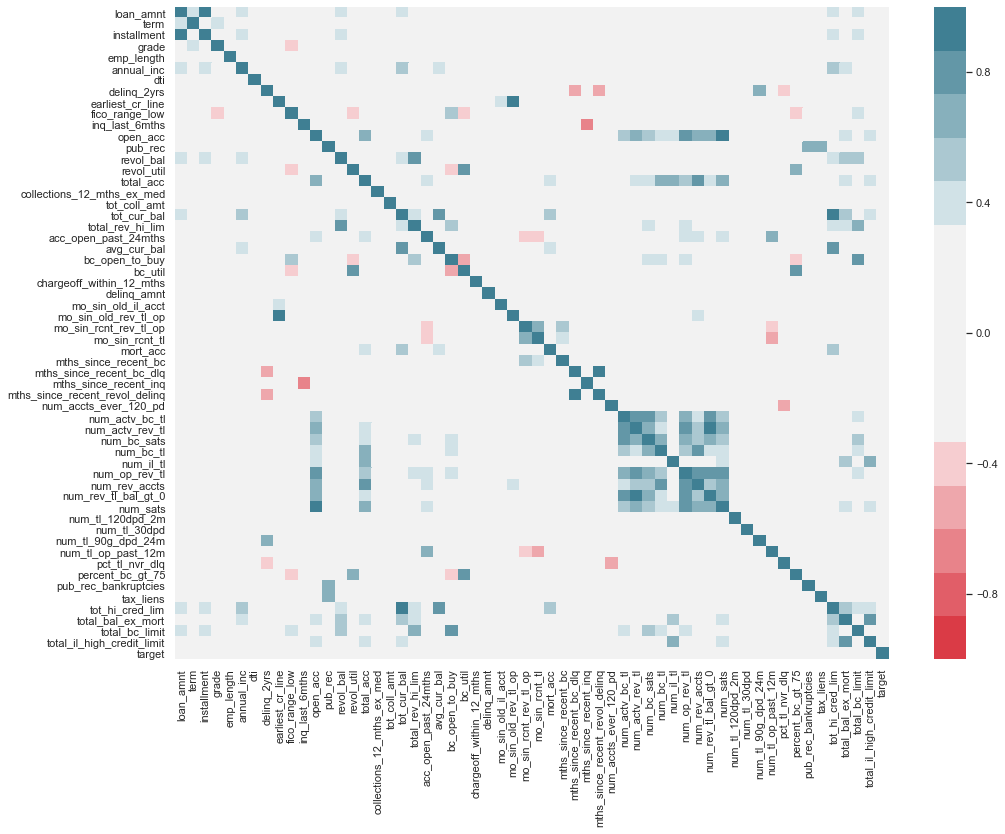

In [62]:
corr = dataset.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.diverging_palette(10, 220, sep=80, n=15));

#### Scatterplot for the mostly correlated features

In [113]:
# the mostly correlated features
corr_list = []
for i in range(corr.shape[1]):
    for j in range(i+1, corr.shape[1]):
        if corr.iat[i,j]>0.9 or corr.iat[i,j]<-0.9:
            corr_list.append((corr.index[i], corr.columns[j], corr.iat[i,j]))
corr_df = pd.DataFrame(corr_list, columns = ['feat_1','feat_2', 'r_pearson'])                    
corr_df.sort_values(by='r_pearson', ascending=False)

,feat_1,feat_2,r_pearson
2,open_acc,num_sats,0.998641
4,num_actv_rev_tl,num_rev_tl_bal_gt_0,0.989523
3,tot_cur_bal,tot_hi_cred_lim,0.976384
0,loan_amnt,installment,0.947946
1,earliest_cr_line,mo_sin_old_rev_tl_op,0.923295


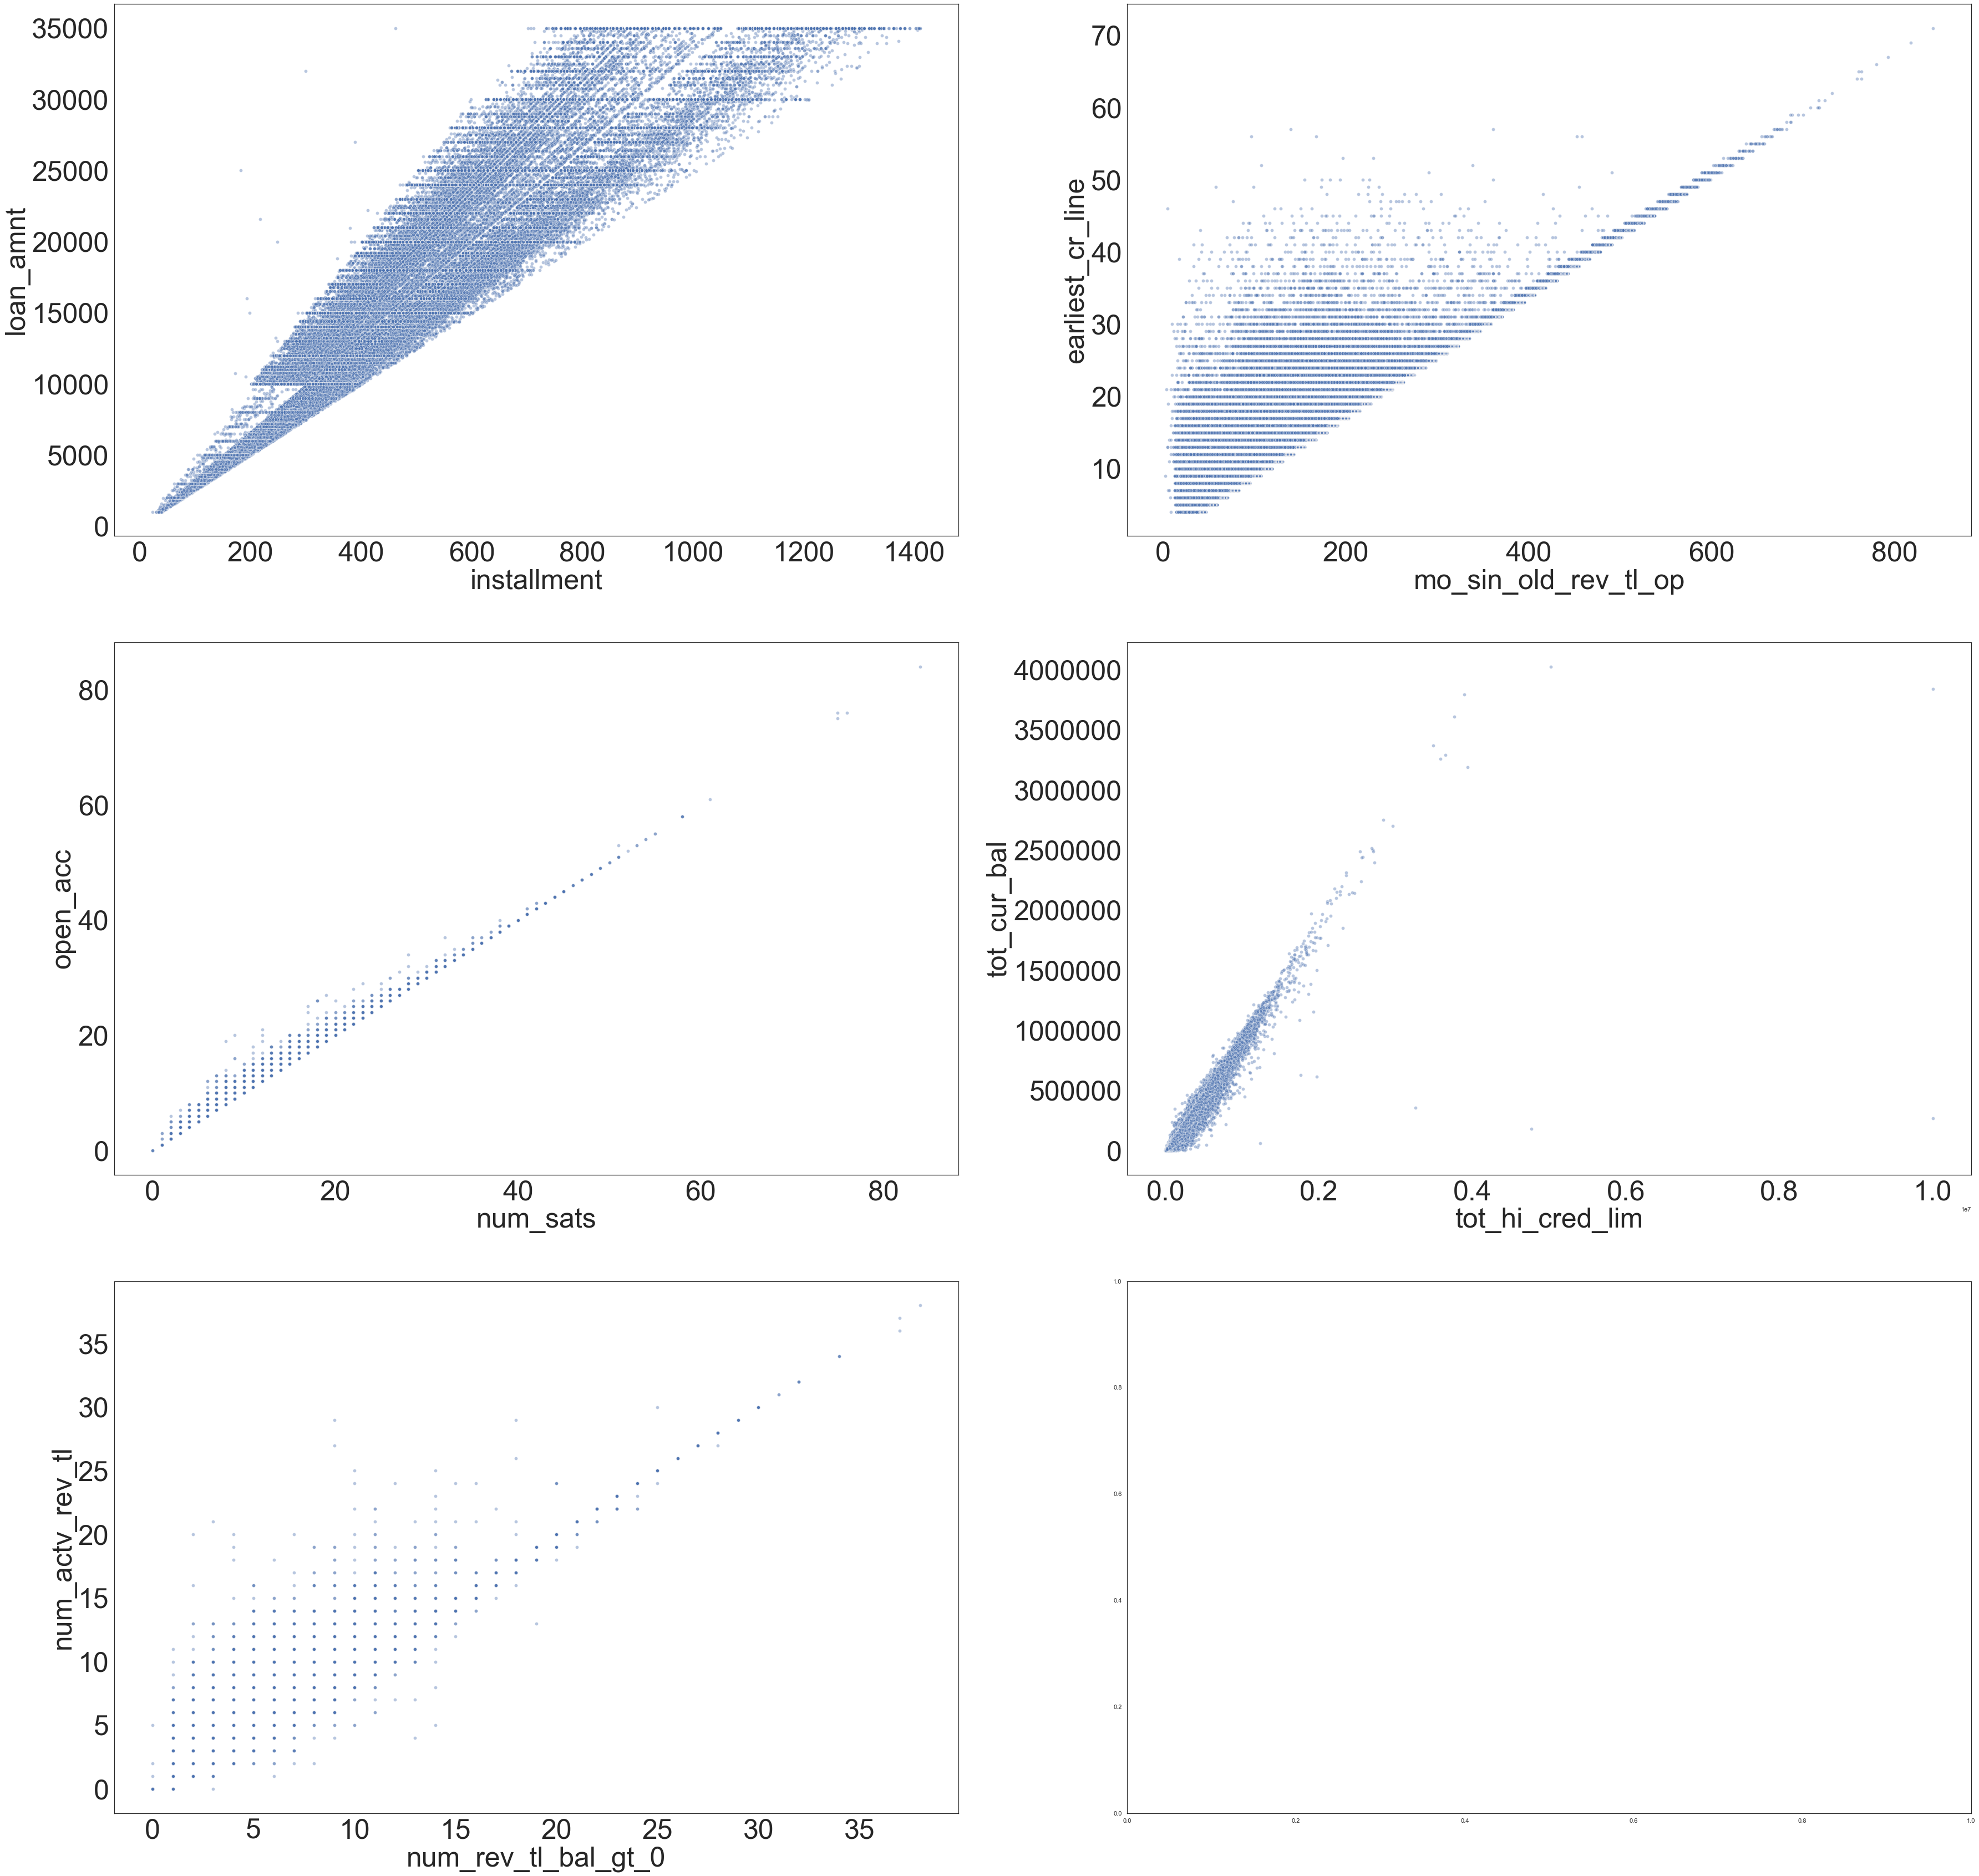

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(60,60))

for corr_data, ax in zip(corr_list, axes.flat):
    sns.scatterplot(corr_data[1], corr_data[0], data=dataset, ax=ax, alpha=0.4)
    ax.set_xlabel(corr_data[1], size = 50)
    ax.set_ylabel(corr_data[0], size = 50)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(50) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(50)

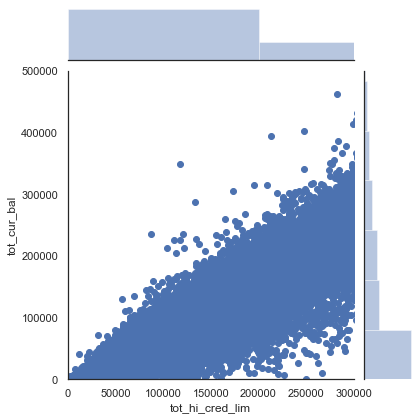

In [90]:
sns.jointplot(x='tot_hi_cred_lim', y='tot_cur_bal', data=dataset, xlim=(0,300000), ylim=(0,500000))

#### Variance Inflation Factor

In [148]:
remove_col = ['home_ownership', 'verification_status', 'purpose', 'target', 'region',
              'revol_util', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct',
              'bc_util', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
              'mths_since_recent_revol_delinq', 'num_tl_120dpd_2m', 'percent_bc_gt_75', 'mths_since_recent_bc']

remove_due_vif = ['total_acc', 'num_rev_tl_bal_gt_0', 'loan_amnt', 'pct_tl_nvr_dlq',
                   'num_op_rev_tl', 'mo_sin_old_rev_tl_op', 'total_bal_ex_mort', 'tot_hi_cred_lim',
                 'fico_range_low', 'num_rev_accts', 'num_actv_bc_tl', 'num_sats']

X = dataset.drop(columns=remove_col+remove_due_vif, axis=1)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
sorted(list(zip(X.columns, vif)), key=lambda x: x[1], reverse=True)

[('open_acc', 20.39319711785412),
 ('term', 17.489487245564817),
 ('num_bc_sats', 13.676306663840988),
 ('num_actv_rev_tl', 12.658999657913233),
 ('grade', 9.920536442283309),
 ('pub_rec', 9.232352136364621),
 ('num_bc_tl', 9.126113137632093),
 ('dti', 8.293876924617985),
 ('acc_open_past_24mths', 8.256365425449662),
 ('earliest_cr_line', 7.696203560168481),
 ('total_rev_hi_lim', 7.1581019377832815),
 ('revol_bal', 6.045130410940004),
 ('installment', 5.938049459859739),
 ('num_tl_op_past_12m', 5.894281785547405),
 ('total_bc_limit', 5.581058563796843),
 ('tax_liens', 4.941001671337152),
 ('num_il_tl', 4.719160991713753),
 ('pub_rec_bankruptcies', 4.689869255145464),
 ('annual_inc', 4.687776423616618),
 ('total_il_high_credit_limit', 4.282764710627437),
 ('tot_cur_bal', 4.008086106838853),
 ('emp_length', 3.3294719389241227),
 ('mo_sin_rcnt_tl', 3.2981815361752553),
 ('mo_sin_rcnt_rev_tl_op', 2.9520593131317647),
 ('mort_acc', 2.713262380660207),
 ('delinq_2yrs', 2.111619437717029),
 (

In [ ]:
x_feats = dataset.columns.to_list()
x_feats.remove('default')

In [ ]:
len(x_feats)

In [ ]:
# x_feats

## Preparing dataset for modeling

In [ ]:
X = pd.get_dummies(dataset[x_feats], drop_first=True)

In [ ]:
y = dataset.default

In [ ]:
y.value_counts()

In [ ]:
X.head()

In [ ]:
X.shape

In [ ]:
# X.columns

### Train-Test Split

In [ ]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) #25%

In [ ]:
y_train.mean()

In [ ]:
y_test.mean()

### Further datacleaning separately for train and test


- annual_inc: in case of annual income we had to handle extreme values (there are many strategies, we were choosing truncating the extreme values to the value of the 99 quantile)
- imputing median values in place of missing values

In [ ]:
imp = SimpleImputer(strategy='median', copy=True, fill_value=None)
imp.fit(X_train)  

X_train_imp = imp.transform(X_train)      
X_test_imp = imp.transform(X_test)

In [ ]:
income_trunc = X_train.annual_inc.quantile(q=0.99)
income_trunc

b_train = X_train_imp > income_trunc
b_test = X_test_imp > income_trunc

X_train_imp[b_train] = income_trunc
X_test_imp[b_test] = income_trunc

In [ ]:
plt.hist(X_train_imp[:,3])
plt.title('Annual income');

### Scaling

The most standard scaling method

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

## Objective: Increasing predictibility of loan defaults from actual default 

### Maximize the F1 score

In [ ]:
def get_metric(y_train, y_probability):
    '''
    inputs: y_train values and from the trained model the y probabilities for default
    output: maximized F1 score, cut-off and the corresponding y_hat
    '''
    y = 0
    F1_score = 0
    cut_off = 0
    for cutoff in np.linspace(0,1,101):
        y_hat = (y_probability > cutoff) * 1
        f1 = f1_score(y_train, y_hat)
        if f1> F1_score:
            F1_score = f1
            cut_off = cutoff
            y = y_hat
    
    print('Recall:', recall_score(y_train, y))
    print('Precision:', precision_score(y_train, y))
    print('F1_score:', F1_score)
    print('Cut_off:', cut_off)
    
    conf_matrix = pd.DataFrame(confusion_matrix(y_train, y),
                                    index=['actual 0', 'actual 1'],
                                    columns=['predicted 0', 'predicted 1'])
    return conf_matrix

 ## Model Selection - Logistic regression

## I. Modeling without imbalance strategy

### A. Baseline: vanilla logistic regression (w/o imbalance strategy)

In [ ]:
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_scaled, y_train)
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]
get_metric(y_train, y_probability)

In [ ]:
p, r, t = precision_recall_curve(y_train, model_vanilla.decision_function(X_train_scaled))

In [ ]:
from inspect import signature
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(r, p, color='b', alpha=0.4, where='post')
plt.fill_between(r, p, color='b', alpha=0.4, **step_kwargs)
plt.xlabel('precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1])
plt.title('Precision-Recall curve');

In [ ]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train, y_probability)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.show()

### B. Lasso regression with different C values (w/o imbalance strategy)

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_scaled, y_train)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))


### C. Ridge regression with different C values (w/o imbalance strategy)

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_scaled, y_train)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    print(get_metric(y_train, y_probability))

### D. Cross-Validation (w/o imbalance strategy)

In [ ]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)

#### Vanilla

In [ ]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_scaled, y=y_train,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [ ]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Ridge

In [ ]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Lasso

In [ ]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

## II. Imbalance Strategy: Random undersampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train) 

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train) 

In [ ]:
pd.Series(y_train_rus).value_counts()

In [ ]:
pd.Series(y_train_ros).value_counts()

### A) Baseline Vanilla (imbalance strategy: undersampling)

In [ ]:
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_rus, y_train_rus)
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]
get_metric(y_train, y_probability)

### D. Cross-validation (imbalance strategy: undersampling)

In [ ]:
#### Vanilla

In [ ]:
cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_rus, y=y_train_rus,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)
y_probability = cross_val_predict(lr_vanilla, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

#### Lasso

In [ ]:
cv_l2 = cross_validate(estimator=l2_reg, X=X_train_rus, y=y_train_rus,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)
y_probability = cross_val_predict(l2_reg, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

#### Ridge

In [ ]:
cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)
y_probability = cross_val_predict(l2_reg, X_train_rus, y_train_rus, cv=cv, method='predict_proba')[:,1]
get_metric(y_train_rus, y_probability)

In [ ]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train_rus, y_probability)

In [ ]:
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_train_rus, y_probability)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.show()

## III. IMBALANCE STRATEGY: SMOTE

In [ ]:
print(y_train.value_counts()) #Previous original class distribution
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled, y_train) 
print(pd.Series(y_train_smote).value_counts()) #Preview synthetic sample class distributi

### A) Baseline Vanilla (SMOTE)

In [ ]:
# Vanilla regression
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_smote, y_train_smote)

In [ ]:
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]

get_metric(y_train, y_probability)

#### This is our selected model, now we test on test set

In [ ]:
y_probability = model_vanilla_balance.predict_proba(X_test_scaled)[:,1]

get_metric(y_test, y_probability)

- Visualization

In [ ]:
p_balance, r_balance, t_balance = precision_recall_curve(y_train, model_vanilla_balance.decision_function(X_train_scaled))

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(13,6))

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})


axs[0].fill_between(r, p, color='#8c8c8c', alpha=0.4, **step_kwargs)
axs[0].set(title='Imbalance Precision-Recall Curve', xlabel='Recall', ylabel='Precision', xlim=(0.0, 1), ylim=(0.0, 1.05))

axs[1].fill_between(r_balance, p_balance, color='r', alpha=0.4, **step_kwargs)
axs[1].set(title='Balanced Precision-Recall Curve', xlabel='Recall', ylabel='Precision', xlim=(0.0, 1), ylim=(0.0, 1.05))
# fig.savefig('Precision-recall curve')

plt.show()

####  B) Lasso regression with different C values

In [ ]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_smote, y_train_smote)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)


#### C) Ridge regression with different C values 

In [ ]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_smote, y_train_smote)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

#### D) Cross-Validation

In [ ]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)


#### Vanilla

In [ ]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_smote, y=y_train_smote,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [ ]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Ridge

In [ ]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Lasso

In [ ]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)